In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from platform import python_version
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as T
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
import PIL
from tqdm import tqdm
from torch.utils.data import  DataLoader, Dataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

In [4]:
!pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for wget: started
  Running setup.py install for wget: finished with status 'done'


  DEPRECATION: wget is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data Preparation
Downloading the dataset from http://www.cs.ucf.edu/~aroshan/index_files/Dataset_PitOrlManh/zipped%20images/part2.zip, this might take several minutes since the dataset is about 5 GB.

In [11]:
import wget
url = "http://www.cs.ucf.edu/~aroshan/index_files/Dataset_PitOrlManh/zipped images/part2.zip"
filename = wget.download(url)
print(filename)

http://www.cs.ucf.edu/~aroshan/index_files/Dataset_PitOrlManh/zipped images/part2.zip
part2.zip


In [48]:
import zipfile
origin_file_path = "origin"

with zipfile.ZipFile(filename,"r") as zip_ref:
    zip_ref.extractall(origin_file_path)

In [59]:
# import cv2
# masked_file_path = "masked"
# if not os.path.exists(masked_file_path):
#     os.mkdir(masked_file_path)

# for image_file in tqdm(os.listdir(origin_file_path)):
#     input_path = os.path.join(origin_file_path, image_file)
#     if not os.path.isfile(input_path):
#         print(f"{input_path} is not a file, skipping...")
#         continue
#     img = PIL.Image.open(input_path)
#     img_ary = np.array(img, dtype=np.uint8)
#     center = (640, 512)
#     width, height = 400, 300
#     startx, starty = center[0] - width//2, center[1] - height//2
#     img_ary[starty:starty+height, startx:startx+width, :] = 0
#     PIL.Image.fromarray(img_ary).save(os.path.join(masked_file_path, image_file))

100%|██████████| 6600/6600 [01:50<00:00, 59.71it/s]


In [3]:

origin_file_path = "origin"
test_folder, train_folder = "test_data", "train_data"

In [19]:
import shutil
file_list = [x for x in os.listdir(origin_file_path) if os.path.isfile(os.path.join(origin_file_path, x))]
file_list.sort()
file_list = np.array(file_list)
train_length = len(file_list) * 4 // 5
# For reproducible purposes
np.random.seed(0)
train_indices = np.random.choice(len(file_list), train_length, replace = False)
train_mask = np.zeros(file_list.shape, dtype=bool)
train_mask[train_indices] = True

test_folder, train_folder = "test_data", "train_data"
if os.path.exists(test_folder):
    shutil.rmtree(test_folder)
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

os.mkdir(test_folder)
os.mkdir(train_folder)

for train_file in tqdm(file_list[train_mask]):
    shutil.copyfile(os.path.join(origin_file_path, train_file), os.path.join(train_folder, train_file))
for test_file in tqdm(file_list[~train_mask]):
    shutil.copyfile(os.path.join(origin_file_path, test_file), os.path.join(test_folder, test_file))

100%|██████████| 1320/1320 [00:01<00:00, 692.23it/s]


## Some steps we can use for data preprocessing

(1280, 1024)
1024 1280


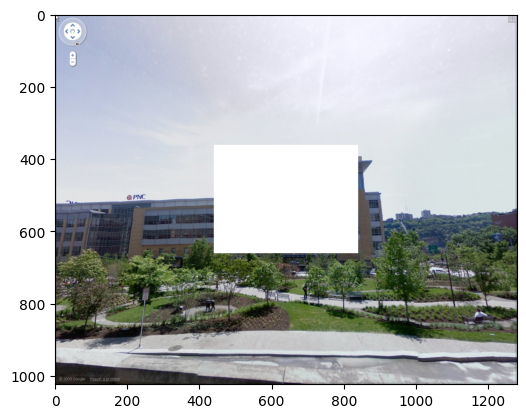

In [4]:
input_path = "train_data\\001100_1.jpg"
img = PIL.Image.open(input_path)
print(img.size)
img = T.ToTensor()(img)

# img_ary = np.array(img, dtype=np.uint8)
# center = (640, 512)
mask_size = (400, 300)
# startx, starty = center[0] - width//2, center[1] - height//2
# img_ary[starty:starty+height, startx:startx+width, :] = 0


channel, y, x = img.size()
print(y, x)
y1, x1 = (y - mask_size[1]) // 2 , (x - mask_size[0])//2
y2, x2 = y1 + mask_size[1], x1 + mask_size[0]
masked_part = img[:, y1:y2, x1:x2]
masked_img = img.clone()
masked_img[:, y1:y2, x1:x2] = 1

plt.imshow(masked_img.permute(1, 2, 0))
# PIL.Image.fromarray(img_ary).save(os.path.join(masked_file_path, image_file))

In [5]:
# load pretrained models
# load_pretrained_models = True
# number of epochs of training
n_epochs = 15
# size of the batches
batch_size = 16
# name of the dataset
# dataset_name = "../input/celeba-dataset/img_align_celeba/img_align_celeba"
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# number of cpu threads to use during batch generation
n_cpu = 4
# dimensionality of the latent space
latent_dim = 100
# size of each image dimension
img_size = 128
# size of random mask
mask_size = 64
# number of image channels
channels = 3
# interval between image sampling
sample_interval = 500

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Calculate output dims of image discriminator (PatchGAN)
patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mask_size=(mask_size, mask_size), train=True):
        self.transform = T.Compose(transforms_)
        self.mask_size = mask_size
        self.train = train
        self.files = sorted([os.path.join(root, x) for x in os.listdir(root) if os.path.isfile(os.path.join(root, x))])
        
    def apply_random_mask(self, img):
        """Randomly masks image"""
        channel, y, x = img.size()
        y1, x1 = np.random.randint(0, y - self.mask_size[1]), np.random.randint(0, x - self.mask_size[0])
        y2, x2 = y1 + self.mask_size[1], x1 + self.mask_size[0]
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        channel, y, x = img.size()
        y1, x1 = (y - self.mask_size[1]) // 2, (x - self.mask_size[0]) // 2
        y2, x2 = y1 + self.mask_size[1], x1 + self.mask_size[0]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, (y1, x1)

    def __getitem__(self, index):
        img = PIL.Image.open(self.files[index % len(self.files)])
        img = self.transform(img)
        if self.train:
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    def __len__(self):
        return len(self.files)

In [7]:
batch_size = 16
transforms_ = [
    T.Resize((img_size, img_size), PIL.Image.BICUBIC),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
dataloader = DataLoader(
    ImageDataset(train_folder, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
test_dataloader = DataLoader(
    ImageDataset(test_folder, transforms_=transforms_, train=False),
    batch_size=12,
    shuffle=False,
    num_workers=0,
)

c:\Users\KandaMaya\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [8]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
            nn.Conv2d(512, 4000, 1),
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [10]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def save_sample(batches_done):
    samples, masked_samples, (y1, x1) = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    y1 = y1[0].item()  # Upper-left coordinate of mask
    x1 = x1[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, y1 : y1 + mask_size, x1 : x1 + mask_size] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, "images/%d.png" % batches_done, nrow=6, normalize=True)

channels = 3
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999


# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator(channels=channels)
discriminator = Discriminator(channels=channels)

# Load pretrained models
# if load_pretrained_models:
#     generator.load_state_dict(torch.load("../input/context-encoder-gan-for-image-inpainting-pytorch/saved_models/generator.pth"))
#     discriminator.load_state_dict(torch.load("../input/context-encoder-gan-for-image-inpainting-pytorch/saved_models/discriminator.pth"))
#     print("Using pre-trained Context-Encoder GAN model!")

cuda = True if torch.cuda.is_available() else False
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [11]:
gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []
# number of epochs of training
n_epochs = 16
# size of the batches
patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

for epoch in range(n_epochs):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for i, (imgs, masked_imgs, masked_parts) in enumerate(tqdm_bar):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

        # Configure input
        imgs = Variable(imgs.type(Tensor))
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))

        ## Train Generator ##
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_parts = generator(masked_imgs)

        # Adversarial and pixelwise loss
        g_adv = adversarial_loss(discriminator(gen_parts), valid)
        g_pixel = pixelwise_loss(gen_parts, masked_parts)
        # Total loss
        g_loss = 0.001 * g_adv + 0.999 * g_pixel

        g_loss.backward()
        optimizer_G.step()

        ## Train Discriminator ##
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(masked_parts), valid)
        fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        gen_adv_loss, gen_pixel_loss, disc_loss
        gen_adv_losses, gen_pixel_losses, disc_losses, counter
        
        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print(batches_done)
            save_sample(batches_done)
            
    torch.save(generator.state_dict(), "saved_models/generator.pth")
    torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

Training Epoch 0 :   0%|          | 0/330 [00:02<?, ?it/s, disc_loss=1.34, gen_adv_loss=1.97, gen_pixel_loss=0.537]

0


Training Epoch 1 :  52%|█████▏    | 170/330 [00:51<00:48,  3.28it/s, disc_loss=0.0383, gen_adv_loss=0.931, gen_pixel_loss=0.306]

500


Training Epoch 3 :   3%|▎         | 10/330 [00:03<01:35,  3.35it/s, disc_loss=0.0201, gen_adv_loss=0.979, gen_pixel_loss=0.277]

1000


Training Epoch 4 :  55%|█████▍    | 180/330 [00:54<00:44,  3.37it/s, disc_loss=0.0202, gen_adv_loss=0.954, gen_pixel_loss=0.271]

1500


Training Epoch 6 :   6%|▌         | 20/330 [00:06<01:33,  3.30it/s, disc_loss=0.0105, gen_adv_loss=0.978, gen_pixel_loss=0.266] 

2000


Training Epoch 7 :  58%|█████▊    | 190/330 [00:58<00:41,  3.34it/s, disc_loss=0.0136, gen_adv_loss=0.969, gen_pixel_loss=0.256]

2500


Training Epoch 9 :   9%|▉         | 30/330 [00:09<01:30,  3.31it/s, disc_loss=0.011, gen_adv_loss=0.974, gen_pixel_loss=0.247]  

3000


Training Epoch 10 :  61%|██████    | 200/330 [01:00<00:38,  3.38it/s, disc_loss=0.00947, gen_adv_loss=0.98, gen_pixel_loss=0.246] 

3500


Training Epoch 12 :  12%|█▏        | 40/330 [00:12<01:30,  3.22it/s, disc_loss=0.0109, gen_adv_loss=0.972, gen_pixel_loss=0.24]  

4000


Training Epoch 13 :  64%|██████▎   | 210/330 [01:03<00:37,  3.22it/s, disc_loss=0.0092, gen_adv_loss=0.979, gen_pixel_loss=0.238] 

4500


Training Epoch 15 :  15%|█▌        | 50/330 [00:14<01:23,  3.34it/s, disc_loss=0.00807, gen_adv_loss=0.982, gen_pixel_loss=0.238]

5000


Training Epoch 15 : 100%|██████████| 330/330 [01:38<00:00,  3.34it/s, disc_loss=0.00832, gen_adv_loss=0.981, gen_pixel_loss=0.232]


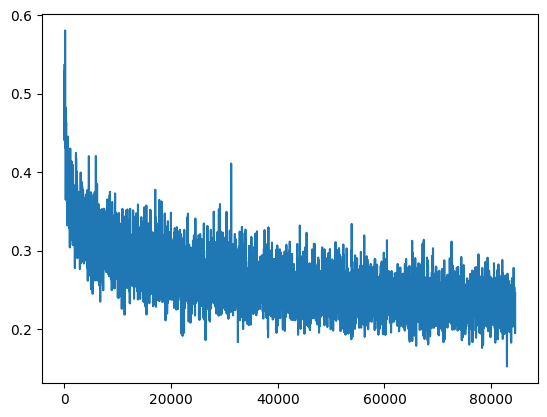

In [19]:
# import plotly
# import plotly.express as px
# import plotly.graph_objects as go
import matplotlib.pyplot as plt

# fig = go.Figure()
plt.plot(counter, gen_pixel_losses)

plt.show()

In [46]:
device = 'cuda'
batch_size = 128

transform = T.Compose([T.Scale(128),
                        T.CenterCrop(128),
                        T.ToTensor(),
                        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = dset.ImageFolder(root=opt.dataroot, transform=transform )
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=Batch_Size,
                                         shuffle=True, num_workers=2)

AttributeError: module 'torchvision.transforms' has no attribute 'Scale'

In [ ]:
number_cats = len(os.listdir(data_dir + '\cats'))
print("Number of training data samples:", number_cats)

In [ ]:
# Chaining image transformations together using torchvision.transforms.Compose method
transform = T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Using next(iter(_)) we obtain a tensor with dimension (batch_size, num_channels, size, size)

In [ ]:
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

images, labels = next(iter(dataloader))
images.shape

In [ ]:
fig, axis = plt.subplots(3, 5, figsize=(15,10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        npimg = images[i].numpy()
        npimg = np.transpose(npimg, (1,2,0))
        ax.imshow(npimg)

## Here we will do data preprocessing with our data